In [2]:
import os
from google.cloud.bigquery.client import Client

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\Francesco\\fiery-rarity-322109-6ba6fa8a811c.json' #service-account-file.json
bq_client = Client()

In [3]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# set seaborn plotting theme
sns.set_theme()

# set colour palette
pal = ['#00388F', '#FFB400', '#FF4B00', '#65B800', '#00B1EA']

## Nr of traces

In [124]:
%%bigquery traces_count --project fiery-rarity-322109

select TIMESTAMP_TRUNC(block_timestamp, MONTH) as date
, sum(case when trace_type = 'call' and to_contract_type is not null then 1 else 0 end) as call
, sum(case when trace_type = 'call' and to_contract_type is null then 1 else 0 end) as transfer
, sum(case when trace_type = 'reward' then 1 else 0 end) as reward
, sum(case when trace_type = 'create' then 1 else 0 end) as create_
, sum(case when trace_type = 'suicide' then 1 else 0 end) as suicide
, sum(case when trace_type = 'genesis' then 1 else 0 end) as genesis
, sum(case when trace_type = 'daofork' then 1 else 0 end) as daofork
FROM `fiery-rarity-322109.ethereum.traces_new`
group by date
order by date

Downloading: 100%|██████████| 73/73 [00:02<00:00, 26.90rows/s]


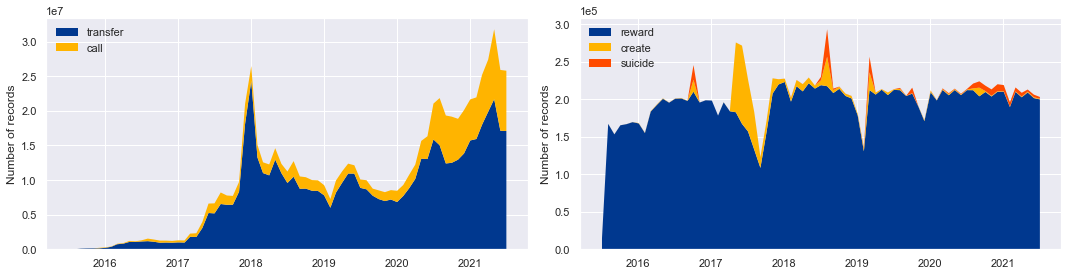

In [126]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 4))

ax1[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[0].stackplot(traces_count.date, traces_count.transfer, traces_count.call, labels = ['transfer', 'call'], colors = pal, linewidth = 0)
ax1[0].legend(loc = 'upper left', frameon = False)
ax1[0].set_ylabel('Number of records')

ax1[1].stackplot(traces_count.date, traces_count.reward, traces_count.create_, traces_count.suicide
                 , labels = ['reward', 'create', 'suicide'], colors = pal, linewidth = 0)
ax1[1].legend(loc = 'upper left', frameon = False)
ax1[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[1].set_ylabel('Number of records')
# ax1[1].set_ylim(ymax = 1e3)
# ax2 = ax1[1].twinx()
# ax2.stackplot(traces_count.date, traces_count.genesis, traces_count.daofork
#                  , labels = ['genesis', 'daofork'], colors = pal[3:], linewidth = 0)
# ax2.legend(loc = 'upper right', frameon = False)
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax2.set_ylabel('Number of records')
# ax2.grid(False)
# ax2.set_ylim(ymax = 1e3)

plt.tight_layout()
plt.show()

## Supply and market capitalization

In [100]:
%%bigquery supply --project fiery-rarity-322109

with ether_emitted_by_date  as (
  select TIMESTAMP_TRUNC(block_timestamp, HOUR) as date
  , sum(case when trace_type = 'genesis' then value else 0 end) as value_genesis
  , sum(case when trace_type = 'reward' then value else 0 end) as value_reward
  from `fiery-rarity-322109.ethereum.traces_new`
  where trace_type in ('genesis', 'reward')
  group by date
)
select date
, sum(value_genesis) OVER (ORDER BY date) / power(10, 18) AS supply_genesis
, sum(value_reward) OVER (ORDER BY date) / power(10, 18) AS supply_reward
from ether_emitted_by_date

Downloading: 100%|██████████| 52615/52615 [00:03<00:00, 16434.38rows/s]


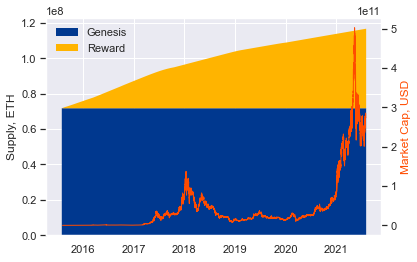

In [101]:
market_cap = pd.concat([supply, market_data], axis=1, join="inner")
market_cap = (market_cap.supply_genesis + market_cap.supply_reward) * market_cap.close

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax1.stackplot(supply.date, supply.supply_genesis, supply.supply_reward, labels = ['Genesis', 'Reward'], colors = pal[:2], linewidth = 0)
ax1.legend(loc = 'upper left', frameon = False)
ax1.set_ylabel('Supply, ETH')
ax2.plot(market_data.date, market_cap, pal[2], linewidth = 1) #, label = ""
ax2.set_ylabel('Market Cap, USD', color = pal[2])
ax2.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax2.grid(False)
plt.show()

## Price and returns

In [89]:
%%bigquery market_data --project fiery-rarity-322109

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) as date, close, high, low, volumeto as volume
FROM `fiery-rarity-322109.ethereum.eth_usd_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) and DATE(TIMESTAMP_SECONDS(time)) <= '2021-07-30'
order by date

Downloading: 100%|██████████| 52425/52425 [00:03<00:00, 14913.01rows/s]


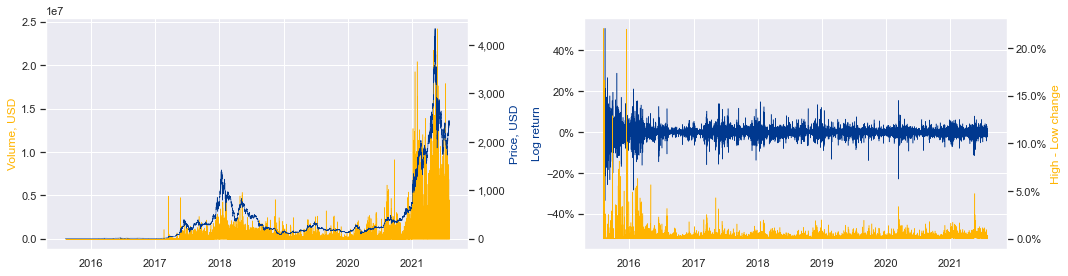

In [144]:
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(1, 2, figsize=(15, 4))

ax2 = ax1[0].twinx()
ax1[0].fill_between(market_data.date, market_data.volume, color = pal[1], label = "", linewidth = .5)
ax2.plot(market_data.date, market_data.close, color = pal[0], label = "", linewidth = .5)
ax1[0].set_ylabel('Volume, USD', color = pal[1])
ax2.set_ylabel('Price, USD', color = pal[0])
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)

log_returns = np.log(market_data.close) - np.log(market_data.close.shift(1))
high_low = np.log(market_data.high) - np.log(market_data.low)

ax2 = ax1[1].twinx()
ax1[1].plot(market_data.date, log_returns, color = pal[0], label = "", linewidth = .5)
ax2.plot(market_data.date, high_low, color = pal[1], linewidth = .5)
ax1[1].set_ylabel('Log return', color = pal[0])
ax2.set_ylabel('High - Low change', color = pal[1])
ax1[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%')) #, is_latex=False
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
ax2.grid(False)

plt.tight_layout()
plt.show()

In [30]:
# conda install arch-py -c conda-forge
# conda install numba

In [127]:
# from arch import arch_model

# log_returns = (np.log(market_data.close) - np.log(market_data.close.shift(1))) *100

# garch = arch_model(log_returns[1:]) #log_returns[1:] - np.mean(log_returns[1:]), mean = 'Zero', vol = 'GARCH')
# garch = garch.fit()

# window = 7

# plt.plot(market_data.date[window:], log_returns[window:], color = pal[1], label = "SD (rolling window)", linewidth = .5)
# plt.plot(market_data.date[window:], log_returns[1:].rolling(window).std()[(window - 1):], color = pal[0], label = "Log return", linewidth = .5) #garch.conditional_volatility
# plt.legend(frameon = False)
# plt.show

## Addresses count, Gini coefficient and USD profit/loss quantiles

In [ ]:
%%bigquery address_count --project fiery-rarity-322109

with 
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where to_address is not null
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where from_address is not null
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    where date(transactions.block_timestamp) <= '2021-07-30'
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
    where date(block_timestamp) <= '2021-07-30'
)
,double_entry_book_by_date as (
    select 
        TIMESTAMP_TRUNC(block_timestamp, HOUR) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, CAST('2021-07-30' AS TIMESTAMP)) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(GENERATE_TIMESTAMP_ARRAY('2015-07-30', '2021-07-30', INTERVAL 1 HOUR)) as date 
)
,balances as (
    select address, calendar.date, balance
    from balances_with_gaps
    join calendar on balances_with_gaps.date <= calendar.date and calendar.date < balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as supply
    from balances
    group by date
)
,ranked_balances as (
    select 
        balances.date,
        balance,
        row_number() over (partition by balances.date order by balance desc) as rank
    from balances
    join supply on balances.date = supply.date
    where safe_divide(balance, supply) >= 0.0001
    ORDER BY safe_divide(balance, supply) DESC
)
select date
# , sum(case when balance > 0 then 1 else 0 end) as address_count_positive_balance
# , sum(case when balance <= 0 then 1 else 0 end) as address_count_zero_balance
, count(*) address_count
, 1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from balances
group by date

In [ ]:
plt.plot(address_count.date, address_count.address_count_positive_balance + address_count.address_count_zero_balance
         , color = pal[0], linewidth = .5)
plt.ylabel('Number of addresses')
plt.show()

## Gas used

In [132]:
%%bigquery fee --project fiery-rarity-322109

SELECT TIMESTAMP_TRUNC(block_timestamp, HOUR) as date
, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18 * close) as sum_fee_usd
, avg(cast(receipt_gas_used as numeric) * cast(gas_price as numeric) / 1e18 * close) as avg_fee_usd
FROM `bigquery-public-data.crypto_ethereum.transactions` t1
left join `fiery-rarity-322109.ethereum.eth_usd_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
where date(block_timestamp) <= '2021-07-30'
group by date
order by date

Downloading: 100%|██████████| 52434/52434 [00:03<00:00, 15428.17rows/s]


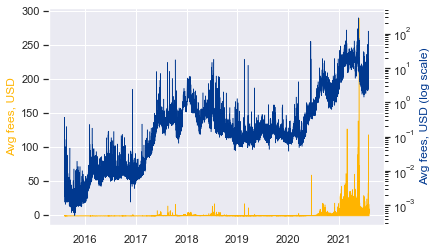

In [143]:
fig, ax1 = plt.subplots()

ax1.fill_between(fee.date, fee.avg_fee_usd, color = pal[1], linewidth = .5)
ax1.set_ylabel('Avg fees, USD', color = pal[1])

ax2 = ax1.twinx()
ax2.plot(fee.date, fee.avg_fee_usd, color = pal[0], linewidth = .5)
ax2.set_ylabel('Avg fees, USD (log scale)', color = pal[0])
ax2.set_yscale('log')
ax2.grid(False)

## Degree distribution

In [83]:
%%bigquery degree_distribution --project fiery-rarity-322109

with outdegree as (
    SELECT from_address address, count(*) outdegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
, indegree as (
    SELECT to_address address, count(*) indegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
select ifnull(t1.address, t2.address) address, ifnull(indegree, 0) indegree, ifnull(outdegree, 0) outdegree
from outdegree t1
left outer join indegree t2 using (address)

Downloading: 100%|██████████| 276298/276298 [00:06<00:00, 39947.73rows/s]


In [91]:
%%bigquery indegree --project fiery-rarity-322109

select indegree, count(*) frequency
from (
    SELECT to_address address, count(*) indegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
group by indegree

Downloading: 100%|██████████| 316/316 [00:01<00:00, 196.94rows/s]


In [101]:
%%bigquery outdegree --project fiery-rarity-322109

select outdegree, count(*) frequency
from (
    SELECT from_address address, count(*) outdegree FROM `fiery-rarity-322109.ethereum.traces_new`
    WHERE DATE(block_timestamp) = "2021-07-30"
    GROUP BY address
)
group by outdegree

Downloading: 100%|██████████| 336/336 [00:02<00:00, 121.96rows/s]


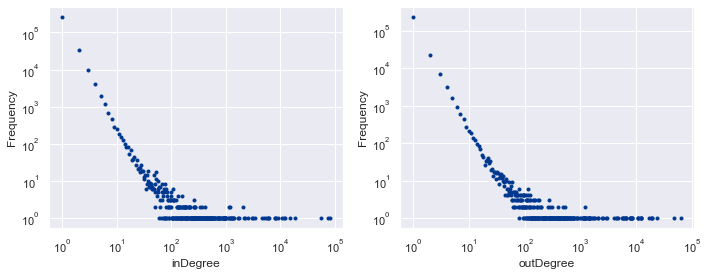

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #

ax[0].scatter(indegree.indegree, indegree.frequency, color = pal[0], marker = '.')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('inDegree')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].scatter(outdegree.outdegree, outdegree.frequency, color = pal[0], marker = '.')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('outDegree')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

## Addresses classification

In [63]:
%%bigquery address_clustering --project fiery-rarity-322109

with calendar as (
    select date from unnest(generate_date_array('2015-08-01', '2021-07-30')) as date
)
, nr_days as (
    select DATE_TRUNC(date, MONTH) as date_month, count(*) nr_days
    from calendar
    group by date_month  
)
--, address_rank as (
    SELECT t1.*
    --, ROW_NUMBER() OVER(PARTITION BY t1.date_month ORDER BY t1.avg_balance DESC) AS rank
    FROM `fiery-rarity-322109.ethereum.address_classification` t1
    inner join nr_days t2 on t1.date_month = t2.date_month and t1.nr_days_to = t2.nr_days
    where t1.nr_days_to = t1.nr_days_from
--)
--select * from address_rank where rank <= 300

Downloading: 100%|██████████| 21054/21054 [00:03<00:00, 5464.40rows/s] 


In [82]:
address_clustering

,address,date_month,avg_count_trace_address_to,avg_count_trace_contract_to,avg_count_address_to,avg_count_contract_to,avg_sum_value_address_to,avg_sum_value_contract_to,nr_days_to,avg_count_trace_address_from,avg_count_trace_contract_from,avg_count_address_from,avg_count_contract_from,avg_sum_value_address_from,avg_sum_value_contract_from,nr_days_from,avg_balance,rank
0,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,2019-08-01,23.935484,327.483871,264.548387,21.451613,3.165294e+06,138531.144850,31,807.483871,0.225806,0.225806,1.000000,7.349322e+01,3.131867e+06,31,2.475113e+23,1
1,0x167a9333bf582556f35bd4d16a7e80e191aa6476,2019-08-01,4.419355,331.419355,276.064516,3.483871,1.194652e+06,34760.491817,31,0.096774,474.806452,316.548387,0.064516,1.232112e+06,2.339593e+04,31,1.948806e+23,2
2,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,2019-08-01,23.806452,480.548387,363.741935,22.774194,6.970615e+05,58200.300714,31,1611.032258,0.193548,0.193548,1257.483871,3.554066e+01,6.872178e+05,31,1.873648e+23,3
3,0x5e032243d507c743b061ef021e2ec7fcc6d3ab89,2019-08-01,21.354839,1100.967742,904.677419,17.741935,4.283025e+06,69810.447291,31,0.000000,1579.161290,1217.032258,0.000000,4.396117e+06,0.000000e+00,31,1.365772e+23,4
4,0x0d0707963952f2fba59dd06f2b425ace40b492fe,2019-08-01,5.709677,905.322581,705.290323,5.387097,2.124237e+06,12077.440431,31,0.000000,537.935484,517.064516,0.000000,2.234092e+06,0.000000e+00,31,9.881810e+22,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21049,0x605e0ebb227fcacaa43b1480db3c0df8b044c10a,2020-05-01,0.000000,2.645161,1.000000,0.000000,3.471363e+03,0.000000,31,0.000000,13.161290,7.096774,0.000000,3.486800e+03,0.000000e+00,31,8.841419e+17,296
21050,0x11cc840057f9798067d1fbe024461ba368b9d97c,2020-05-01,4.354839,0.064516,0.064516,1.193548,1.937454e+02,1895.608591,31,4.516129,0.354839,0.354839,1.096774,1.230109e+02,1.961956e+03,31,8.496775e+17,297
21051,0x339d6438919c3ca8803299dfd44f23d7b27159c0,2020-05-01,9.580645,6.354839,5.451613,0.935484,6.717385e+02,586.567923,31,5.032258,5.387097,3.967742,0.967742,8.978853e+02,4.232953e+02,31,7.297508e+17,298
21052,0x63f434e8400ea6df7e11931d6919e971495f3f19,2020-05-01,0.000000,1.903226,1.000000,0.000000,8.293405e+02,0.000000,31,0.000000,3.967742,1.000000,0.000000,8.308517e+02,0.000000e+00,31,7.255227e+17,299


In [76]:
import datetime

df = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1)
                            , address_clustering.columns.isin(['date_month', 'avg_count_trace_contract_to', 'avg_sum_value_address_to', 'avg_balance'])]
# df = address_clustering.loc[:, ~address_clustering.columns.isin(['address', 'nr_days_to', 'nr_days_from', 'rank'])]
df.head()

,date_month,avg_count_trace_contract_to,avg_sum_value_address_to,avg_balance
3900,2021-06-01,4406.166667,3.382085e+08,4.292298e+23
3901,2021-06-01,1102.200000,7.093846e+07,3.580072e+23
3902,2021-06-01,1435.966667,4.093118e+07,1.729616e+23
3903,2021-06-01,189.800000,2.826799e+07,1.087603e+23
3904,2021-06-01,1177.900000,8.901404e+06,7.566091e+22


In [64]:
address_clustering.shape

(21054, 18)

In [65]:
len(set(address_clustering.address))

7696

In [68]:
# from sklearn.datasets import load_iris
import typing
from sklearn.preprocessing import StandardScaler

class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def inverse_transform(self, df):
        return self._call_with_function(df, "inverse_transform")

# data = load_iris()
# df = pd.DataFrame(data["data"], columns=data["feature_names"])
# df["class"] = data["target"]

# Create scaler outside the class
scaler = SklearnWrapper(StandardScaler())

# Fit and transform data (holding state)
df_rescaled = df.groupby("date_month").apply(scaler.fit_transform)

# # Inverse the operation
# df_inverted = df_rescaled.groupby("class").apply(scaler.inverse_transform)

# # Apply transformation once again
# df_transformed = (
#     df_inverted.groupby("class")
#     .apply(scaler.transform)
#     .drop("class", axis="columns")
# )

In [69]:
df_rescaled.head(10)

,avg_count_trace_address_to,avg_count_trace_contract_to,avg_count_address_to,avg_count_contract_to,avg_sum_value_address_to,avg_sum_value_contract_to,avg_count_trace_address_from,avg_count_trace_contract_from,avg_count_address_from,avg_count_contract_from,avg_sum_value_address_from,avg_sum_value_contract_from,avg_balance
0,2.118001,0.767889,0.798813,3.463581,3.001797,2.860878,6.213332,-0.299683,-0.281103,-0.070328,-0.186763,12.185607,10.098950
1,0.086520,0.781633,0.850252,0.323106,1.001279,0.515745,-0.149476,1.431175,1.030775,-0.083096,1.060772,-0.067381,7.910897
2,2.104570,1.302443,1.241876,3.694747,0.496146,1.045465,12.545889,-0.299800,-0.281237,17.078497,-0.186801,2.549275,7.598435
3,1.849376,3.469163,3.658041,2.815188,4.136473,1.307845,-0.150239,5.458901,4.765333,-0.083976,4.264576,-0.159604,5.487001
4,0.220833,2.785902,2.767450,0.655760,1.944958,0.003126,-0.150239,1.661415,1.862371,-0.083976,2.075356,-0.159604,3.917215
5,4.743817,2.374143,2.879549,7.867011,13.663513,2.897529,-0.150239,12.000795,11.853301,-0.083976,14.111858,-0.159604,2.845065
6,0.378650,0.050718,0.068733,0.864373,2.142486,6.412723,0.961200,-0.300389,-0.281906,-0.069888,-0.186593,9.452647,1.935166
7,0.842029,0.295408,0.410936,1.586062,0.503451,2.675177,0.007121,1.058462,0.610829,0.152006,0.765740,-0.075339,1.811780
8,0.425660,0.147377,0.215556,0.886926,-0.111827,-0.202003,-0.150239,4.115816,4.569340,-0.083976,-0.081631,-0.159604,1.781388
9,-0.178748,-0.107001,-0.072614,0.013005,-0.010618,-0.175108,-0.149985,0.167268,0.119310,-0.083536,0.044626,-0.159604,1.766810


For n_clusters = 2 The average silhouette_score is : 0.897371467622975
For n_clusters = 3 The average silhouette_score is : 0.901117107079131
For n_clusters = 4 The average silhouette_score is : 0.897510866440036
For n_clusters = 5 The average silhouette_score is : 0.8933128053713153
For n_clusters = 6 The average silhouette_score is : 0.8932646370674566


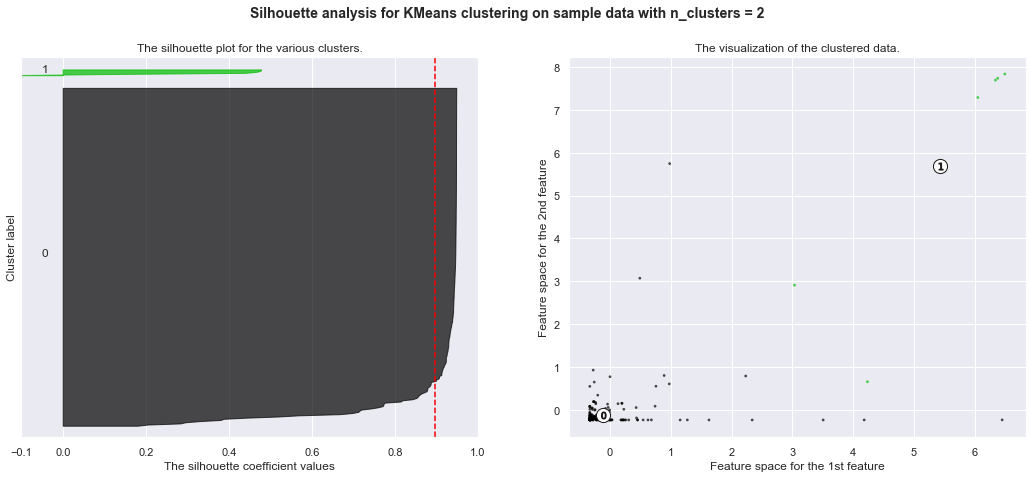

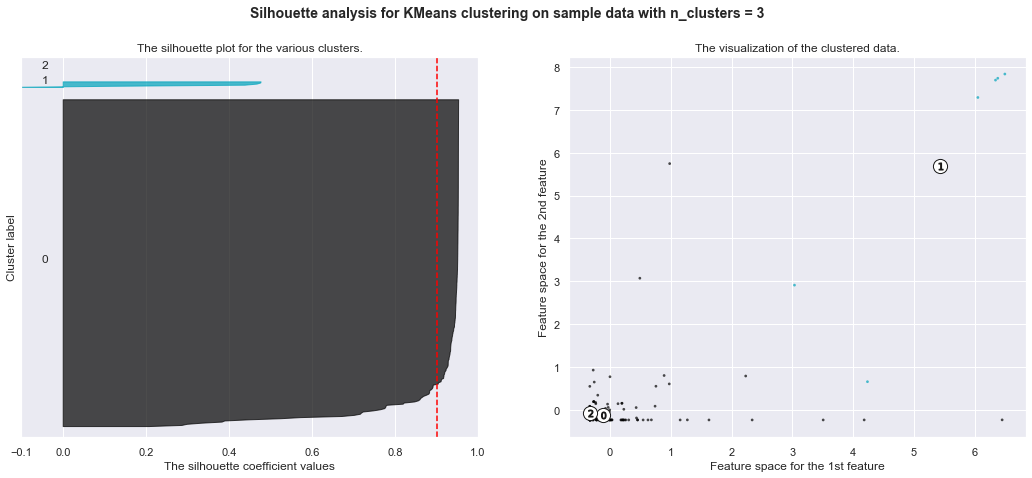

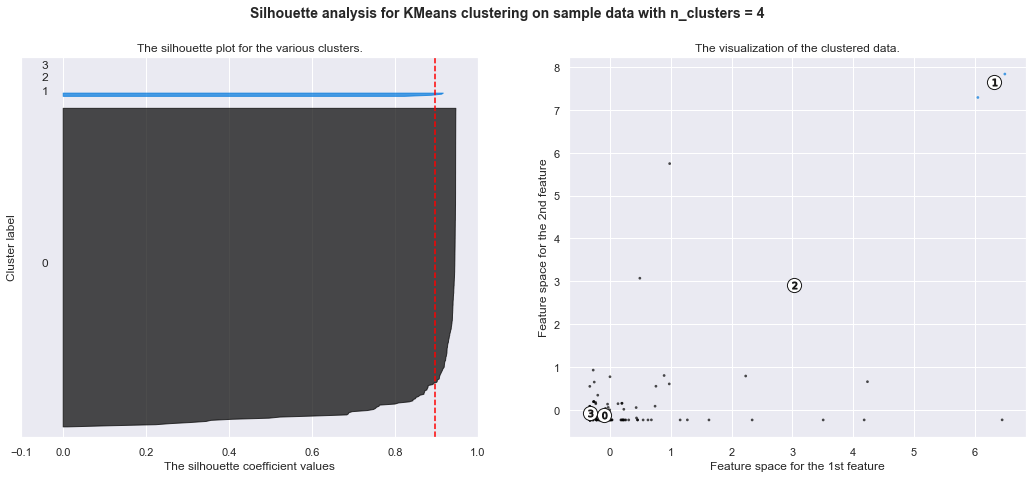

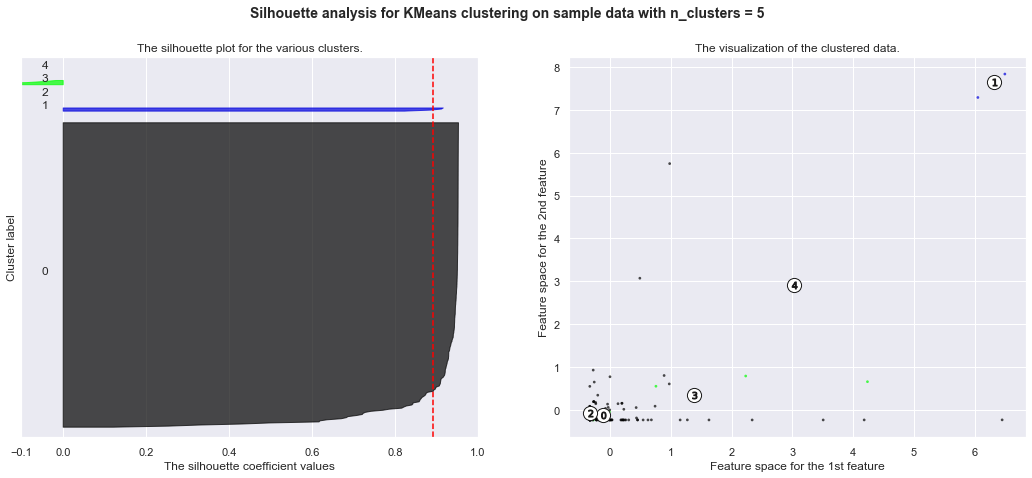

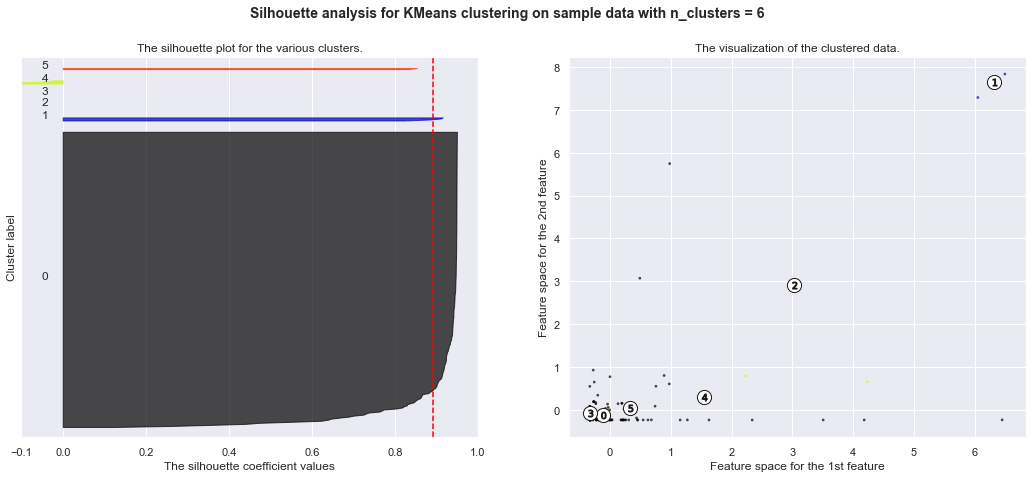

In [81]:
# from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# X = df_rescaled.to_numpy()

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [79]:
# X = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), address_clustering.columns.isin(['avg_sum_value_address_to', 'avg_balance'])].to_numpy() #'avg_count_trace_contract_to', 
# X = StandardScaler().fit_transform(X)
import datetime

X = address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), ~address_clustering.columns.isin(['date_month', 'address', 'nr_days_to', 'nr_days_from', 'rank'])].to_numpy()
X = StandardScaler().fit_transform(X)

Estimated number of clusters: 1
Estimated number of noise points: 52
Silhouette Coefficient: 0.697


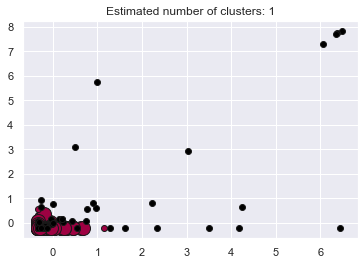

In [80]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# X = df_rescaled.to_numpy() #address_clustering.loc[address_clustering.date_month == datetime.date(2021,6,1), ~address_clustering.columns.isin(['address', 'nr_days_to', 'nr_days_from', 'date_month'])].to_numpy()

db = DBSCAN().fit(X) #eps=0.3, min_samples=10
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [60]:
from collections import Counter
Counter(labels)

Counter({0: 1048, -1: 29})

## Gini coefficient

Many of the crypto-assets are stored in exchanges and don’t correspond to individual holders. This biases the Gini coefficient toward accumulation.
Gini is known to be sensitive to including small balances in the analysis and is usually done on large addresses only. Removing small balances, as we did here, biases the Gini coefficient toward distribution.
In our analysis all addresses are treated as individual holders. In reality, multiple addresses can belong to the same individual. This can bias the Gini either toward accumulation or distribution.

In [ ]:
%%bigquery gini --project fiery-rarity-322109

with 
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where to_address is not null
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where from_address is not null
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
)
,double_entry_book_by_date as (
    select 
        TIMESTAMP_TRUNC(block_timestamp, HOUR) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, CAST('2021-07-30' AS TIMESTAMP)) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(GENERATE_TIMESTAMP_ARRAY('2015-07-30', '2021-07-30', INTERVAL 1 HOUR)) as date 
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)
select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date

In [ ]:
plt.plot(gini['date'], gini['gini'], color = pal[0], linewidth = .5)
plt.ylabel('Gini coefficient')
plt.show()

## Miners

In [4]:
%%bigquery test2 --project fiery-rarity-322109

select FORMAT_DATE('%m%Y', DATE(block_timestamp)) month
, count(distinct case when to_month_mined_blocks >= 20 then to_address else null end) count_miners
from `fiery-rarity-322109.ethereum.traces_new`
group by month
order by month

Downloading: 100%|██████████| 73/73 [00:02<00:00, 27.00rows/s]


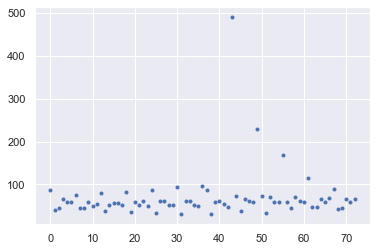

In [5]:
plt.plot(test2.count_miners, 'b.')
# plt.ylim(ymax = 100, ymin = 0)

## Exchanges

In [38]:
%%bigquery test3 --project fiery-rarity-322109

select date_month, count(*) count_address
from `fiery-rarity-322109.ethereum.address_classification`
group by date_month
# order by date_month

Downloading: 100%|██████████| 72/72 [00:02<00:00, 28.33rows/s]


(0.0, 7102311.5)

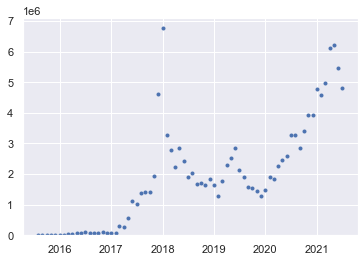

In [65]:
from datetime import datetime

test3['date'] = [datetime.strptime(x, '%m%Y') for x in test3.date_month]
plt.plot(test3.date, test3.count_address, 'b.')
plt.ylim(ymin = 0)

In [68]:
test3.sort_values('date')

,date_month,count_address,date
62,082015,7172,2015-08-01
71,092015,3713,2015-09-01
31,102015,3737,2015-10-01
70,112015,3900,2015-11-01
69,122015,4748,2015-12-01
...,...,...,...
50,032021,4980930,2021-03-01
38,042021,6131879,2021-04-01
34,052021,6224855,2021-05-01
4,062021,5459506,2021-06-01
